In [4]:
import rastervision as rv
from rasterio.transform import rowcol
import faiss
from rastervision.utils.files import download_if_needed
from rastervision.utils.misc import numpy_to_png
import numpy as np
import pandas as pd
import PIL

import torch
from torch.autograd import Variable
from tile2vec.tilenet import make_tilenet

import matplotlib.pyplot as plt

tmp_dir = '/opt/data/tmp'

In [18]:
# Paths

#index_path = '/opt/data/rv_root/eval/iowa-wind-turbines/embeddings.idx'
#model_path = '/opt/data/rv_root/train/iowa-wind-turbines/model.ckpt'
#window_list_path = '/opt/data/rv_root/eval/iowa-wind-turbines/scene-windows.csv'

index_path = 's3://raster-vision-rob-dev/tile2vec/eval/iowa-wind-turbines/embeddings.idx'
model_path = 's3://raster-vision-rob-dev/tile2vec/train/iowa-wind-turbines/model.ckpt'
window_list_path = 's3://raster-vision-rob-dev/tile2vec/eval/iowa-wind-turbines/scene-windows.csv'

In [19]:
def read_chip(uri, window):
    raster_source = rv.RasterSourceConfig.builder(rv.GEOTIFF_SOURCE) \
                                         .with_uri(src_img) \
                                         .with_channel_order([0,1,2]) \
                                         .build() \
                                         .create_source(tmp_dir)
    with raster_source.activate():
        return raster_source.get_chip(window)

In [20]:
index_path = download_if_needed(index_path, tmp_dir)
index = faiss.read_index(index_path)

2019-02-22 03:03:43:rastervision.utils.files: INFO - Downloading s3://raster-vision-rob-dev/tile2vec/eval/iowa-wind-turbines/embeddings.idx to /opt/data/tmp/s3/raster-vision-rob-dev/tile2vec/eval/iowa-wind-turbines/embeddings.idx


In [21]:
src_img = '/opt/data/sample-naip/m_4309361_se_15_1_20170820.tif'
raster_source = rv.RasterSourceConfig.builder(rv.GEOTIFF_SOURCE) \
                                     .with_uri(src_img) \
                                     .with_channel_order([0,1,2]) \
                                     .build() \
                                     .create_source(tmp_dir)

In [23]:
def load_model():
    """Load the model in preparation for one or more prediction calls."""

    local_model_path = download_if_needed(model_path, tmp_dir)

    in_channels = len(raster_source.channel_order)
    z_dim = 512

    model = make_tilenet(in_channels=in_channels, z_dim=z_dim)
    if model_path.startswith('s3'):
        model.load_state_dict(torch.load(local_model_path, map_location='cpu'))
    else:
        model.load_state_dict(torch.load(local_model_path))
    model.eval()
    return model
tilenet = load_model()

2019-02-22 03:14:03:rastervision.utils.files: INFO - Downloading s3://raster-vision-rob-dev/tile2vec/train/iowa-wind-turbines/model.ckpt to /opt/data/tmp/s3/raster-vision-rob-dev/tile2vec/train/iowa-wind-turbines/model.ckpt


In [70]:
# Transform point identified in QGIS
with raster_source.activate():
    offset = 25
    transform = raster_source.image_dataset.transform
    pixel_point = rowcol(transform, 464473.1, 4766429.8)
    pixel_point = (pixel_point[0] - offset, pixel_point[1] - offset)
    print(pixel_point)
    chip = raster_source.get_chip(rv.core.Box(pixel_point[0], pixel_point[1], pixel_point[0] + 100, pixel_point[1] + 100))
    

(1694, 408)


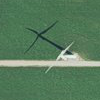

In [71]:
PIL.Image.fromarray(chip)

In [72]:
tile = np.moveaxis(chip, -1, 0)
tile = np.expand_dims(tile, axis=0)
# Scale to [0, 1]
tile = tile / 255

tile = torch.from_numpy(tile).float()
tile = Variable(tile)
z = tilenet.encode(tile)
z = z.data.numpy()
print(z)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.69942950e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.84089234e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00563705e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.53236872e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.74698368e-01 0.00000000e+00
  1.51830745e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.34522706e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.57502913e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.19090658e-01 0.00000000e+00 0.00000000e+00 2.21804716e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

In [73]:
k = 20
D, I = index.search(z, k)

In [37]:
I

array([[1518243, 1518069, 1516425, 1517893,  524681, 1512253,  741698,
        1512428, 1537898,  514530]])

In [38]:
# Find the images in the scene list
window_list_path = download_if_needed(window_list_path, tmp_dir)
df = pd.read_csv(window_list_path)

In [74]:
results = []
for i in I[0]:
    row = df[df['idx'] == i].iloc[0]
    box = rv.core.Box(row['src_window_xmin'],
                      row['src_window_ymin'],
                      row['src_window_xmax'],
                      row['src_window_ymax'])
    results.append(read_chip(row['src_scene_id'], box))


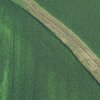

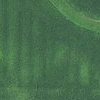

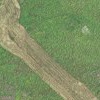

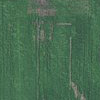

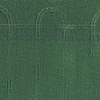

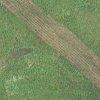

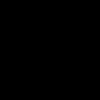

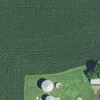

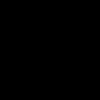

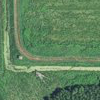

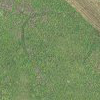

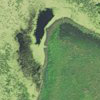

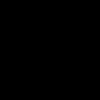

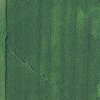

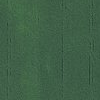

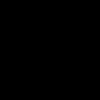

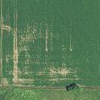

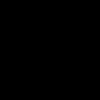

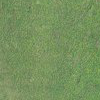

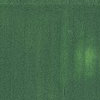

In [75]:
for result in results:
    display(PIL.Image.fromarray(result))

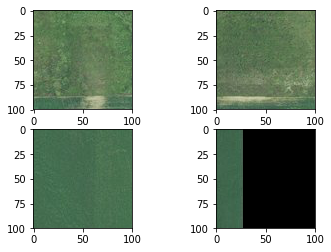

In [56]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(results[0])
axarr[0,1].imshow(results[1])
axarr[1,0].imshow(results[2])
axarr[1,1].imshow(results[3])